In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
!pip install scanpy
import scanpy as sc
import os, sys
!echo "deb http://downloads.skewed.de/apt/ bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool
sys.path.append('/content/drive/My Drive/phd/hsbm-occam/')

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Executing: /tmp/apt-key-gpghome.wMvxs1bxip/gpg.1.sh --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: "Tiago de Paula Peixoto <tiago@skewed.de>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Hit:1 http://downloads.skewed.de/apt bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://ppa.lau

In [0]:
os.chdir('/content/drive/My Drive/phd/datasets/gtex/10')

# Download data or get the data

In [0]:
df = pd.read_csv("mainTable_all.csv", index_col=0)
df.index = [g[:15] for g in df.index]
df.drop_duplicates(subset=df.index.name, ignore_index=False, inplace=True)
df_files = pd.read_csv("files.dat",index_col=0)

In [0]:
df = pd.read_csv('https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_reads.gct.gz', skiprows=2, sep='\t', index_col=0)
df_files=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)
df_files = df_files[df_files.index.isin(df.columns)]

In [0]:
print(df.head())
df.to_csv("mainTable_all_counts.csv", index=True, header=True)

In [0]:
#df = pd.read_csv('https://storage.googleapis.com/gtex_analysis_v8/rna_seq_data/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_tpm.gct.gz', skiprows=2, sep='\t', index_col=0)
df_files=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)
df_files = df_files[df_files.index.isin(df.columns)]

In [0]:
rs = np.random.RandomState(seed=42)
samples = pd.DataFrame(columns=df_files.columns)
for site in df_files.groupby('SMTS').count().sort_values('SMTSD',ascending=False).index[:10]:
    samples = samples.append(df_files[df_files['SMTS']==site].sample(100, random_state=rs))

In [0]:
samples.groupby('SMTS').count().sort_values('SMTSD',ascending=False)

In [0]:
df[samples.index].to_csv("mainTable_counts.csv")

In [0]:
df_files.to_csv("files.dat")

In [0]:
os.getcwd()

# Select HVG

In [0]:
samples = df_files
genes = df.index

In [0]:
hde=pd.read_csv("HDE_Lung.csv",index_col=0).index.values
genes = list(filter(lambda g: g in df.index, hde))

In [0]:
adata = sc.AnnData(X=df.reindex(index=genes, columns=samples.index).transpose(), obs=samples)

In [0]:
adata_log = sc.pp.log1p(adata, copy=True)
sc.pp.highly_variable_genes(adata_log, n_top_genes=3000, n_bins=50)

In [0]:
sc.pl.highly_variable_genes(adata_log, log=False, save='hvg_counts.pdf')

In [0]:
hvg = adata_log.var[adata_log.var['highly_variable']==True].index
samples = adata_log.obs.index

In [0]:
df.loc[hvg, samples].to_csv("mainTable_hv_counts.csv")

#Select HK

In [0]:
hk = pd.read_excel("HK_exons.xlsx")["Gene Name"].unique()

In [0]:
hgcn_url = "https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_app_name&col=md_ensembl_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_name&format=text&submit=submit"
df_conversion=pd.read_csv(hgcn_url, sep="\t")

In [0]:
df_hk_ensg = df_conversion[(df_conversion["Approved symbol"].isin(hk))&(df_conversion["Ensembl ID(supplied by Ensembl)"].isin(df.index))]["Ensembl ID(supplied by Ensembl)"].drop_duplicates().values

In [0]:
df_hk = df.reindex(index=df_hk_ensg)
df_hk.to_csv("mainTable_hk.csv", index=True)

# Use SBM

In [0]:
from sbmtm import sbmtm
model = sbmtm()

In [0]:
samples = df_files
genes = hvg

In [0]:
model.make_graph_from_BoW_df(df.reindex(index=genes, columns=samples.index).dropna().applymap(lambda tpm: np.log2(tpm+1)))
model.save_graph("graph.xml.gz")
model.g

In [0]:
model.load_graph("graph.xml.gz")
model.g

In [0]:
config = "counts"
os.system(f"mkdir -p {config}")
os.chdir(f"{config}")
model.fit(n_init=1, parallel=True, verbose=True, B_min=5, B_max=500)
model.save_data()

In [0]:
pd.read_csv("mainTable.csv", index_col=0).applymap(lambda tpm: np.log10(tpm+1)).max().hist()

In [0]:
pd.read_csv("mainTable_log.csv", index_col=0).max().hist()

In [3]:
os.getcwd()

'/content/drive/My Drive/phd/datasets/gtex/10'

In [0]:
import graph_tool as gt
import seaborn as sns
from sbmtm import sbmtm

In [0]:
model = sbmtm()

In [0]:
import matplotlib.pyplot as plt
def load_and_print(graph="graph.xml.gz", **kwargs):
  model.load_graph(graph)
  print(model.g)
  data = gt.spectral.adjacency(model.g, weight=model.g.edge_properties["count"]).toarray()
  data = data[1000:,:1000]
  sns.heatmap(data, **kwargs)

<Graph object, undirected, with 3999 vertices and 483377 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fab399300b8>


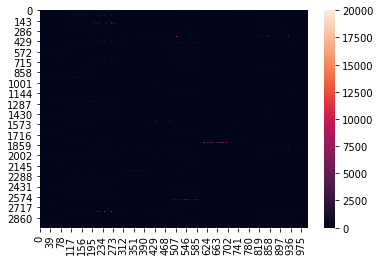

In [41]:
load_and_print("graph.xml.gz", vmax=2e4)

<Graph object, undirected, with 3999 vertices and 483377 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fab338a6278>


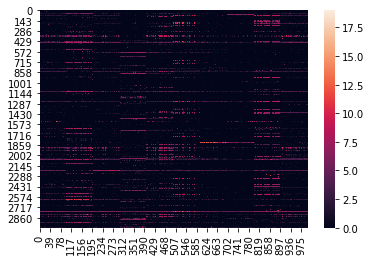

In [33]:
load_and_print("graph_log.xml.gz")

<Graph object, undirected, with 3999 vertices and 2924902 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fab338beeb8>


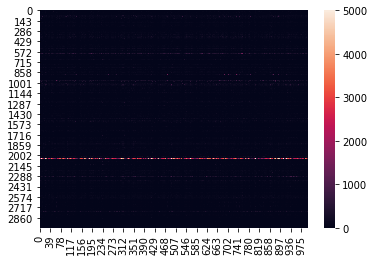

In [44]:
load_and_print("graph_hk.xml.gz", vmax=5e3)

<Graph object, undirected, with 3999 vertices and 176387 edges, 2 internal vertex properties, 1 internal edge property, at 0x7fab37b4e898>


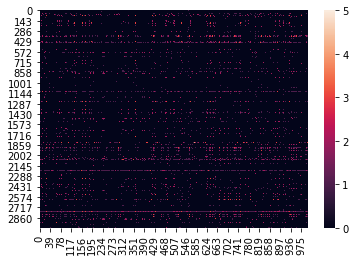

In [36]:
load_and_print("graph_log10.xml.gz")